<a href="https://colab.research.google.com/github/raspopovaa/Pet-Project-Data-Analyst/blob/main/%D0%98%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BD%D0%B0%D0%B4%D1%91%D0%B6%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%B7%D0%B0%D1%91%D0%BC%D1%89%D0%B8%D0%BA%D0%BE%D0%B2/%22%D0%98%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BD%D0%B0%D0%B4%D1%91%D0%B6%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%B7%D0%B0%D1%91%D0%BC%D1%89%D0%B8%D0%BA%D0%BE%D0%B2%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

Описание данных
* children — количество детей в семье
* days_employed — общий трудовой стаж в днях
* dob_years — возраст клиента в годах
* education — уровень образования клиента
* education_id — идентификатор уровня образования
* family_status — семейное положение
* family_status_id — идентификатор семейного положения
* gender — пол клиента
* income_type — тип занятости
* debt — имел ли задолженность по возврату кредитов
* total_income — ежемесячный доход
* purpose — цель получения кредита

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [ ]:
#Этот код позволяет запускать лематизацию pymystem3 в colab. 
#После установки,нужно презапустить среду выполнения
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

Загружаем необходимые нам библиотеки.

In [ ]:
%pip install pymystem3 -U
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)
plt.style.use('dark_background')
import pandas as pd
from pymystem3 import Mystem
m = Mystem()

%pip install catboost
from catboost import CatBoostClassifier
model = CatBoostClassifier(verbose=100)

Импортируем бибилиотеку pandas, pymystem2, matplotlib и загружаем таблицу. Pandas для работы с таблицами, matplotlib для визуализации, pymystem3 для лематизации. Catboost для определения скоринговой модели позволяющей выявлять недобросовестных клиентов.

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Используем метод info() для выявлнния пропущеных значений в таблице

Используем метод .head(), для визуальной оценки данных.

In [4]:

data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Посмотрим на числовые значения таблицы поближе.

In [5]:
[data[col].describe() for col in data.columns]

[count    21525.000000
 mean         0.538908
 std          1.381587
 min         -1.000000
 25%          0.000000
 50%          0.000000
 75%          1.000000
 max         20.000000
 Name: children, dtype: float64, count     19351.000000
 mean      63046.497661
 std      140827.311974
 min      -18388.949901
 25%       -2747.423625
 50%       -1203.369529
 75%        -291.095954
 max      401755.400475
 Name: days_employed, dtype: float64, count    21525.000000
 mean        43.293380
 std         12.574584
 min          0.000000
 25%         33.000000
 50%         42.000000
 75%         53.000000
 max         75.000000
 Name: dob_years, dtype: float64, count       21525
 unique         15
 top       среднее
 freq        13750
 Name: education, dtype: object, count    21525.000000
 mean         0.817236
 std          0.548138
 min          0.000000
 25%          1.000000
 50%          1.000000
 75%          1.000000
 max          4.000000
 Name: education_id, dtype: float64, count    

В данных есть много артефактов, которые мы исправим ниже.

###**Вывод:**

Использовав метод info и head, можно сделать вывод, что таблица содержит 21525 строк, 12 столбцов. Столбцы имеют разний тип данных. Таблица удобная для анализа данных - в каждом столбце храняться значения, каждая строка содержит одно наблюдение, к которому приязанны значения разных переменных. Название столбцов без пробелов, несколько слов разделяются нижним подчеркиванием, на одном языке и в одном регистре, отображают в краткой форме какого рода информация содержиться в каждом столбце. Столбцы 'days_employed' (общий трудовой стаж в днях) и 'total_income' (ежемесячный доход) имеют 19351 заполненых строк вместо 21525, т.е имеют около 10 % пропусков значений. Так же в столбце 'days_employed' есть отрицательные значения, чего не может быть с трудовым стажем. Так же отрицательные значения есть в столбце 'children', в столбцах 'education', 'family_status' и income_type буквы разного регистра, столбец 'gender' содержит неверное значение XNA. В строке 'dob_years' есть нулевые значения, что недопустимо. Скорее всего это технические ошибки.  Так же предположу, что пропуски в столбцах 'days_employed' (общий трудовой стаж в днях) и 'total_income' (ежемесячный доход) созданны намеренно и связанно это с видом кредита (т.е. есть кредиты не предполагающие предоставление информации о трудовом стаже, и ежемесячном доходе). Интересно, есть ли связь между заполнением этих строк и возвратом кредита в срок. Но вернемся к заданию, необходимо провести предобработку данных для выявления артефактов содержащих недостоверные данные.

## Шаг 2. Предобработка данных

### Обработка пропусков

Посмотрим сколько процентов сотавляют пропущенные значения.

In [6]:
pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
children,0.000000
days_employed,10.100000
dob_years,0.000000
education,0.000000
education_id,0.000000
family_status,0.000000
family_status_id,0.000000
gender,0.000000
income_type,0.000000
debt,0.000000


Посмотрим на клиентов имеющих пропуски в трудовом стаже.

In [7]:
data.query('days_employed != days_employed')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости


Было найдено 2174 значения NaN. Нам нужно либо заменить NaN на другое значение, либо удалить полностью строку с пропущенным значением. У каждого метода есть минусы и плюсы. Ответим на вопрос: "Какой метод лучше в нашем случае?" Удаление строки не целесообразно (10% от выбоки, как никак), так как удаление полностью всех строк может повлиять на результат исследования. Добавление нового значения тоже может повлиять на результат. Так как пропуски в трудовом стаже и общем доходе совпадают, предположу, что это клиенты взявшие кредитный продукт не учитывающий длительности стажа и размера дохода. В нашем случае можем заменить NaN на медианные значения. Так же у нас есть отризацельные значения, думаю это баг в выгрузке, заменим их на положительные.

In [8]:
data['days_employed'] = data['days_employed'].abs()
data['total_income'] = data['total_income'].abs()

Для столбца income_type, предлагаю так же заполнить пропуски медианными значениями в соответствующей группе. Сгруппируем данные по категориям income_type и вычислим их медиану по доходу и трудовому стажу. Эти данные будем использовать для проверки нашей функции для замены пропусков.

In [9]:
data.groupby('income_type', as_index=False).agg({'total_income': ['count', 'mean', 'median'],'days_employed': ['count', 'mean', 'median']})

income_type total_income  ...  days_employed               
                          count  ...           mean         median
0      безработный            2  ...  366413.652744  366413.652744
1        в декрете            1  ...    3296.759962    3296.759962
2      госслужащий         1312  ...    3399.896902    2689.368353
3        компаньон         4577  ...    2111.524398    1547.382223
4        пенсионер         3443  ...  365003.491245  365213.306266
5  предприниматель            1  ...     520.848083     520.848083
6        сотрудник        10014  ...    2326.499216    1574.202821
7          студент            1  ...     578.751554     578.751554

[8 rows x 7 columns]

  
Напишем функцию no_non_value для замены пропусков в нужном нам столбце  на медианные значения в категории. Используем медиану для исключения экстремальных значений в расчетах.


In [10]:

def no_non_value(df, value, category):
    for type_unique in df[category].unique():
        df.loc[(df[value].isna())&(df[category] ==type_unique), value] = \
        df.loc[df[category] ==type_unique, value].median()
    return df

Прменим функцию для запонения пропущенных значений в столбце total_income, на медианные значения в категории income_type.

In [11]:
data = no_non_value(data, 'total_income', 'income_type')

Смотрим что все строки с пропущенными значениями в столбце total_income, по категории income_type (мы смотрим по пенсионерам) заполнены.

In [12]:
data.query('income_type == "пенсионер" and days_employed != days_employed')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,118514.486412,сыграть свадьбу
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,118514.486412,строительство жилой недвижимости
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,118514.486412,сыграть свадьбу
67,0,NaN,52,высшее,0,женат / замужем,0,F,пенсионер,0,118514.486412,покупка жилья для семьи
145,0,NaN,62,среднее,1,женат / замужем,0,M,пенсионер,0,118514.486412,строительство недвижимости
...,...,...,...,...,...,...,...,...,...,...,...,...
21311,0,NaN,49,среднее,1,женат / замужем,0,F,пенсионер,0,118514.486412,покупка жилья для сдачи
21321,0,NaN,56,Среднее,1,женат / замужем,0,F,пенсионер,0,118514.486412,операции с недвижимостью
21414,0,NaN,65,среднее,1,женат / замужем,0,F,пенсионер,0,118514.486412,покупка своего жилья
21415,0,NaN,54,среднее,1,женат / замужем,0,F,пенсионер,0,118514.486412,операции с жильем


In [13]:
data = no_non_value(data, 'total_income', 'income_type')

In [14]:
data = no_non_value(data, 'days_employed', 'income_type')

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод:**

Для определения и подсчёта пропущенных значений таблицы применим метод .isna() в сочетании с методом .mean(). В результате мы видим два столбца days_employed и total_income с 2174 (10% от всех данных) строками пропущенных значений. Заполним данные строки используя написанную нами функцию no_non_value. Она заполнит пропуски медианными значениями вычисленными в соответствующей группе клиентов. Удаление данных строк методом .dropna() не целесообразно, так как удаление полностью всех строк может повлиять на результат исследования.

### Замена типа данных

In [16]:
data.dtypes

children              int64
days_employed       float64
dob_years             int64
education            object
education_id          int64
family_status        object
family_status_id      int64
gender               object
income_type          object
debt                  int64
total_income        float64
purpose              object
dtype: object

Самый простой способ преобразовать столбец данных в другой тип - использовать .astype()

In [17]:
data['days_employed'] = data['days_employed'].astype('int')
data['children'] = data['children'].astype('int')


Целесообразно изменить тип данных в трех столбцах. 'days_employed'(общий трудовой стаж в днях), 'children'(количество детей в семье), так как из их смысла понятно что они могут быть только целочисленные. 

Так же столбцы 'days_employed', 'children' имют отрицательные значения, что также не являеться верным. Создаем функцию для изменения минуса на плюс. Либо можем применить метод .abs

In [18]:
def modul(num):
    if num < 0:
        num_p = num * -1
        return num_p
    else:
        return num

In [19]:
data['days_employed'] = data['days_employed'].apply(modul)
data['children'] = data['children'].apply(modul)

Проверим, что получилось.

In [20]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


**Вывод**

Мы изменили вещественный тип (float) данных на целочисленный (int). После анализа таблицы были определены столбы с вещественным типом данных 'days_employed', 'children'. Для их изменнеия выбрали метод astype() как самый простой и универсальный. Отрицательные значения изменили в рамках общей задачи предобработки данных.

### Обработка дубликатов

Проверим на дубликаты и удалим их.

In [21]:
data['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

Cтроки отличаются регистром букв. Чтобы учесть такие дубликаты, все символы в строке приводят к нижнему регистру вызовом метода lower(). В Pandas синтаксис .str.lower(). Тем самым мы удалили все дубликаты

In [22]:
data['education'] = data['education'].str.lower()
data['education'].duplicated().sum()


21520

In [23]:
data['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

По аналогии поступим и с другими столцами имющими категориальные типы данных.

In [24]:
data['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

In [25]:
data['family_status'] = data['family_status'].str.lower()
data['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

In [26]:
data['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Наблюдаем появление в данных третьего пола. Кстати в США официально 54 типа половой принадлежности))). В данном случае будем считать это дубликатом появившимся по технической причине, заменим его на f (так как это всего один случай не имеет значения на что менять, можно просто удалить его)

In [27]:
data = data.replace('XNA', 'f')
data['gender'] = data['gender'].str.lower()
data['gender'].value_counts()

f    14237
m     7288
Name: gender, dtype: int64

In [28]:
data['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

Мы видим разные категории, некоторые из которых не отражают тип занятосяти. Предлагаю объеденить некоторые категории в схожие катерии. Сотрудник, безработный и пенсионер.

In [29]:
data['income_type'] = data['income_type'].replace({'компаньон':'сотрудник', 'госслужащий':'сотрудник', 'предприниматель':'сотрудник', 'студент':'безработный',  'в декрете':'безработный', })

In [30]:
data['income_type'].value_counts()

сотрудник      17665
пенсионер       3856
безработный        4
Name: income_type, dtype: int64

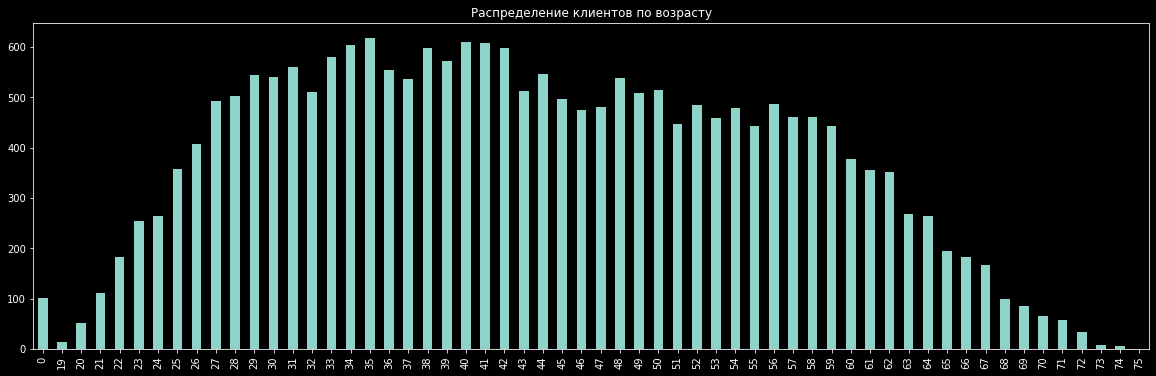

In [31]:
plt.title('Распределение клиентов по возрасту')
data['dob_years'].value_counts().sort_index(ascending=True).plot(kind='bar')
plt.show()

В столбце есть 101 значение равно 0. Предполагаю, что эо так же техническая ошибка. Так как этих строй мало, предлагаю удалить их.

In [32]:
data = data.query('dob_years != 0')

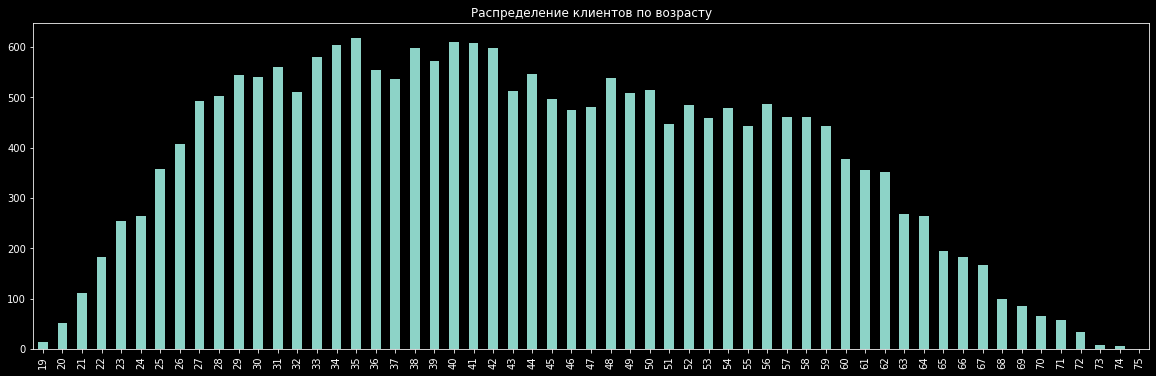

In [33]:
plt.title ('Распределение клиентов по возрасту')
data['dob_years'].value_counts().sort_index(ascending=True).plot(kind='bar')
plt.show()

**Вывод**

В таблице присутствовало множество дубликатов. Мы удалили дубликаты приведя все знаки в строках к нижнему регистру, в ручном режиме объеденили некоторые группы значений, заменили отсутствующие значения на средние по столбцу. Данные дубликаты возникали в связи с техническими ошибками. Скорее всего эти данные в систему заводили специалисты банка и каждый специалист заводил по своему.

#### Лемматизация

Для устранения дублей в столбце -цели кредита,воспользуемся лемматизацией.Для лемматизаци будем использовать бибилитеку pymystem3. 

Создадим функию для лемматизации значений

In [34]:
def lemmatize(str):
    return ' '.join(m.lemmatize(str))


С помощью метода apply пременим фунцию для лемматизации слов в столбце purpose.

In [35]:
data['lemm_purpose'] = data['purpose'].apply(lemmatize)
data.head(3)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,lemm_purpose
0,1,8437,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875.639453,покупка жилья,покупка жилье \n
1,1,4024,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080.014102,приобретение автомобиля,приобретение автомобиль \n
2,0,5623,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885.952297,покупка жилья,покупка жилье \n


**Вывод**

Применив созданную нами фенкцию Lemmatize для лемматизции значений в столбце purpose, можно выделить несколько целей кредита - Автомобиль, жилье, недвижимость, свадьба, образование. Разобьем целина эти категории.

### Категоризация данных

Для наглядности последующих расчетов, разобьем на категории столбцы lemm_purpose, dob_years, children, total_income, .

In [36]:
def lem_group(word):
    if 'свадьба' in word:
        return 'кредит на общие нужды'
    elif 'образование' in word:
        return 'кредит на образование'
    elif 'жилье' in word or 'недвижимость' in word or "жильё" in word:
        return 'кредит на недвижимость'
    elif 'автомобиль' in word:
        return 'автокредит'
    else:
        return 'нужно проверить лемму'

In [37]:
data['lemm_purpose_group'] = data['lemm_purpose'].apply(lem_group)
data['lemm_purpose_group'] = data['lemm_purpose_group'].astype('category')#Для оптимизации изменим тип данных на категории
data['lemm_purpose_group'].value_counts()

кредит на недвижимость    10793
автокредит                 4293
кредит на образование      4004
кредит на общие нужды      2334
Name: lemm_purpose_group, dtype: int64

Цели кредита разделили исходя из текущих видов кредитования в банках. Кредит на авто - Автокердит, кредит на приобретение жилья - кредит на недвижимость, кредит на разные цели -кредит на общие нужды, на образование -  "кредит на образование"

Категоризируем возраст клиента на молодых, взрослых и старых. Эти значения пригодяться для оценки взаимосвязи между возрастом заемщиков и возвратом кдита в срок. Для этого создадим фнкцию age_group и применим к соответствующему столбцу.

In [38]:
def age_group(age):
    if age <= 30:
        return 'молодой'
    elif age <= 64:
        return 'взрослый'
    elif age >= 65:
        return 'старый'
    else:
        return 'нужно проверить значение'
    
       

In [39]:
data['dob_age_group'] = data['dob_years'].apply(age_group)
data['dob_age_group'] = data['dob_age_group'].astype('category')
data['dob_age_group'].value_counts()


взрослый    16802
молодой      3723
старый        899
Name: dob_age_group, dtype: int64

Категоризируем количество детей клиента на бездетных и с детьми . Эти значения пригодяться для оценки взаимосвязи между количеством детей у заемщиков и возвратом кдита в срок. Для этого создадим фнкцию children_group и применим к соответствующему столбцу.

In [40]:
def children_group(children):
    try:
        if children == 0:
            return 'бездетные'
        else:
            return 'есть дети'
               
    except:
        return 'нужно проверить'

In [41]:
data['dob_children_group'] = data['children'].apply(children_group)
data['dob_children_group'] = data['dob_children_group'].astype('category')
data['dob_children_group'].value_counts()

бездетные    14080
есть дети     7344
Name: dob_children_group, dtype: int64

Категоризируем доход клиента на без дохода, бехных, со средним доходом и с высоким доходом. Эти значения пригодяться для оценки взаимосвязи между доходом у заемщиков и возвратом кдита в срок. Для этого создадим фнкцию total_income_group и применим к соответствующему столбцу.

In [42]:
def total_income_group(total_income):
    if total_income == 0:
        return 'без дохода'
    elif total_income <= 50000:
        return 'бедный'    
    elif total_income < 100000:
        return 'средний доход'
    elif total_income >= 100000:
         return 'высоких доход'
    else:
        return 'нужно проверить значение'

In [43]:
data['total_income_group'] = data['total_income'].apply(total_income_group)
data['total_income_group'] = data['total_income_group'].astype('category')
data['total_income_group'].value_counts()

высоких доход    16984
средний доход     4070
бедный             370
Name: total_income_group, dtype: int64

Сгруппируем данные семейного положения, пусть 0 будет не женат, все остальное 1.

In [44]:
data['family_status_group'] = data['family_status_id'].isin([1,2,3,4])*1

In [45]:
data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,lemm_purpose,lemm_purpose_group,dob_age_group,dob_children_group,total_income_group,family_status_group
0,1,8437,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875.639453,покупка жилья,покупка жилье \n,кредит на недвижимость,взрослый,есть дети,высоких доход,0
1,1,4024,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080.014102,приобретение автомобиля,приобретение автомобиль \n,автокредит,взрослый,есть дети,высоких доход,0
2,0,5623,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885.952297,покупка жилья,покупка жилье \n,кредит на недвижимость,взрослый,бездетные,высоких доход,0
3,3,4124,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628.550329,дополнительное образование,дополнительный образование \n,кредит на образование,взрослый,есть дети,высоких доход,0
4,0,340266,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616.077870,сыграть свадьбу,сыграть свадьба \n,кредит на общие нужды,взрослый,бездетные,высоких доход,1


**Вывод**

Для выполнения последующего задания мы категоризировали данные в необходимых нам столбца. Категоризация поможет нам выявить влияние данных нам параметров на возврат кредита в срок. Для этого мы создали ряд функций для каждого слобца сожержащих несколько условий.

## Шаг 3. Ответим на вопросы

### Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [46]:

print(f"В общем по всей выборке мы имеем {round(data['debt'].mean()*100)} % должников.")

В общем по всей выборке мы имеем 8 % должников.


Для выявления зависимости сгруппируем данные по полученному нами столбцу 'dob_children_group' и сделаем выводы по столбцу 'debt' с помощью вывода количества, среднего значения.

In [47]:
data.groupby('dob_children_group').agg({'debt': ['count','mean']}).style.highlight_max()


Мы видим, что количество должников на 2% выше у клиентов имеющих детей.

Предлагаю углубиться в данные и посмотреть есть корреляция возврата кредита у клиентов имеющих детей и нет в зависимости от вида кредита.

In [48]:
data.pivot_table(index=['dob_children_group'], columns= 'lemm_purpose_group', values='debt', aggfunc='mean').style.highlight_max()


lemm_purpose_group,автокредит,кредит на недвижимость,кредит на образование,кредит на общие нужды
dob_children_group,,,,
бездетные,0.085241,0.067072,0.086940,0.073377
есть дети,0.108666,0.081857,0.102920,0.089421


В целом мы так же видим что, бездетные платят лучше, так же видим что хуже платят клиенты с детьмя взявщие автокредит и кредит на образование, чем клиенты в целом.

Если посмотреть на данные в разрезе получаемого дохода, видим что так же бездетные платят лучше.

In [49]:
data.pivot_table(index=['dob_children_group'], columns= 'total_income_group', values='debt', aggfunc='mean').style.highlight_max()


total_income_group,бедный,высоких доход,средний доход
dob_children_group,,,
бездетные,0.054264,0.075844,0.074288
есть дети,0.080357,0.091323,0.095605


### Есть ли зависимость между семейным положением и возвратом кредита в срок?

Для выявления зависимости сгруппируем полученый нами столбец 'family_status_id' и сделаем выводы по столбцу 'debt' с помощью вывода количества, суммы и среднего значения.

In [50]:
data.groupby('family_status_group').agg({'debt': ['count','mean']}).style.highlight_max()

Сгруппируем те же даннве но более подробно, оценим выборки клиентов. 

In [51]:
data_pivot_f = data.pivot_table(index=['family_status_group'], columns = 'debt', values='days_employed', aggfunc='count')
data_pivot_f.reset_index()
data_pivot_f['Количество заемщиков в группе'] = data_pivot_f[0] + data_pivot_f[1]
data_pivot_f['доля должников в %'] = data_pivot_f[1] / data_pivot_f['Количество заемщиков в группе'] * 100
data_pivot_f.sort_values(by = 'доля должников в %', ascending = False).style.highlight_max()

debt,0,1,Количество заемщиков в группе,доля должников в %
family_status_group,,,,
1,8287,806,9093,8.863961
0,11404,927,12331,7.517638


Вывод, женатые на 1% чаще не выплачивают кредиты. Учитывая, что средняя просрочка по все выборке 8% можно сделать вывод,что семейное положение не влияет на вероятность возврата кредита

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [52]:
data.groupby('total_income_group').agg({'debt': ['count', 'mean'],}).style.background_gradient()

In [53]:
data_pivot_t = data.pivot_table(index=['total_income_group'], columns = 'debt', values='days_employed', aggfunc='count')
data_pivot_t.reset_index()
data_pivot_t['Количество заемщиков в группе'] = data_pivot_t[0] + data_pivot_t[1]
data_pivot_t['доля должников в %'] = data_pivot_t[1] / data_pivot_t['Количество заемщиков в группе'] * 100
data_pivot_t.sort_values(by = 'доля должников в %', ascending = False).style.background_gradient()

debt,0,1,Количество заемщиков в группе,доля должников в %
total_income_group,,,,
высоких доход,15604,1380,16984,8.125294
средний доход,3740,330,4070,8.108108
бедный,347,23,370,6.216216


Вывод, бедные возвращают кредиты на 2% лучше, чем остальные. Клиенты с высоким и средним доходом, так же не выходят за рамки общего среднего размера доли просрочки.

### Как разные цели кредита влияют на его возврат в срок?

In [54]:
data.groupby('lemm_purpose_group').agg({'debt': ['count', 'mean'],}).style.background_gradient()

In [55]:
data_pivot_p = data.pivot_table(index=['lemm_purpose_group'], columns = 'debt', values='days_employed', aggfunc='count')
data_pivot_p.reset_index()
data_pivot_p['Количество заемщиков в группе'] = data_pivot_p[0] + data_pivot_p[1]
data_pivot_p['доля должников в %'] = data_pivot_p[1] / data_pivot_p['Количество заемщиков в группе'] * 100
data_pivot_p.sort_values(by = 'доля должников в %', ascending = False).style.background_gradient()

debt,0,1,Количество заемщиков в группе,доля должников в %
lemm_purpose_group,,,,
автокредит,3893,400,4293,9.317494
кредит на образование,3634,370,4004,9.240759
кредит на общие нужды,2150,184,2334,7.883462
кредит на недвижимость,10014,779,10793,7.217641


<div class="alert alert-block alert-info">
    
С помощью сводной таблицы определили доли должников в каждой группе. Сровнив полученные доли видим что максимальное и минимальное значение отличаеться на 2%. По автокредитам просрочки возникают у 9,3% заемщиков, по кредитам на недвижимость у 7,2 % заемщиков. Думаю взаимосвязь незначительная. 
</div>

##  Вывод

Ни наличие детей, ни семейное положение, ни уровень дохода, или вид кредита, достаточно сильно не вляют на возврат кредита в срок. Либо проведенного анализа недостаточно для выявления зависимости. Предлагаю использовать **CatBoost** для определния клиентов которые возможно не вернут кредит. CatBoost-это алгоритм машинного обучения, который использует градиентное повышение на деревьях решений.

### Catboost

Зададим выбоку данных для обучения

In [56]:
train = data.sample(frac=0.7,random_state=42).copy()

Оставим часть данных для проверки полученных результатов обучения

In [57]:
val = data[~data.index.isin(train.index)].copy()

In [58]:
data.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose', 'lemm_purpose', 'lemm_purpose_group',
       'dob_age_group', 'dob_children_group', 'total_income_group',
       'family_status_group'],
      dtype='object')

Выберем столбцы для обучения X_col и целевую переменную y_col, так же укажем столбцы с категориальными данными.

In [59]:
X_col = ['children', 'days_employed', 'education', 
       'gender', 'income_type',
       'lemm_purpose_group',
       'dob_age_group', 'dob_children_group', 'total_income_group',
       'family_status_group']
y_col = ['debt']
cat_features = ['education', 'gender', 'income_type', 'lemm_purpose_group',
       'dob_age_group', 'dob_children_group', 'total_income_group',
       'family_status_group']

In [60]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(verbose=100)

Приступим к обучению модели

In [61]:
model.fit(train[X_col],train[y_col],
          
          eval_set=(val[X_col],val[y_col]),

          cat_features=cat_features
          )

Learning rate set to 0.061856
0:	learn: 0.6324861	test: 0.6318381	best: 0.6318381 (0)	total: 134ms	remaining: 2m 13s
100:	learn: 0.2730084	test: 0.2666774	best: 0.2666774 (100)	total: 4.09s	remaining: 36.4s
200:	learn: 0.2671035	test: 0.2667685	best: 0.2663305 (156)	total: 8.86s	remaining: 35.2s
300:	learn: 0.2608161	test: 0.2674864	best: 0.2663305 (156)	total: 15.5s	remaining: 36s
400:	learn: 0.2556930	test: 0.2682774	best: 0.2663305 (156)	total: 21.7s	remaining: 32.5s
500:	learn: 0.2512761	test: 0.2688484	best: 0.2663305 (156)	total: 26.8s	remaining: 26.7s
600:	learn: 0.2469368	test: 0.2695644	best: 0.2663305 (156)	total: 29.4s	remaining: 19.5s
700:	learn: 0.2425656	test: 0.2704429	best: 0.2663305 (156)	total: 32.1s	remaining: 13.7s
800:	learn: 0.2383342	test: 0.2713777	best: 0.2663305 (156)	total: 34.8s	remaining: 8.64s
900:	learn: 0.2350399	test: 0.2720585	best: 0.2663305 (156)	total: 37.4s	remaining: 4.11s
999:	learn: 0.2311588	test: 0.2731458	best: 0.2663305 (156)	total: 40s	rema

Лучший результат модели был на 156 иттерации. Модель с вероятностью 26,6% может предсказать не возврат кредита.

Посмотрем на веса модели. Что даст нам понимание о влиянии фитчей на модель и на верояность невозврата кредита.

In [62]:
fi = pd.DataFrame({'w':model.feature_importances_,'name':X_col})

In [63]:
fi.sort_values('w',ascending=False,inplace=True)

In [64]:
fi

,w,name
1,22.038879,days_employed
2,20.779717,education
5,11.369304,lemm_purpose_group
3,10.460516,gender
6,10.089550,dob_age_group
8,7.258878,total_income_group
9,5.856086,family_status_group
0,4.581500,children
7,4.262631,dob_children_group
4,3.302938,income_type


Применив машинное обучение мы определили, что набольшее влияние на верояность просрочки по кредиту оказывают трудовой стаж и образование. Уровень дохода, наличие детей и семеное пложение влияют на возврат кредита в меньшей степени.

## Шаг 4. Общий вывод


  Нам была дана таблица с информацией о заемщика имющих разные параметры. Нам было необходимо определить как влияет семейное положение, количество детей, уровень доходаи, цель кредина на возврат кредита в срок. Для этого мы проанализировали таблицу, выявили пропуски и земенили на среднее значение по соответствующей группе, визуально определили дубликаты, часть дубликатов удалили, часть из них исчезла после приведения стороки к нижнему регистру, заменили неправдоподобные значения. Используя инструмены pandas мы убрали весь мусор и привели данные к необходимому типу. Затем катологизировали данные для более наглядного расчета необходимых параметров. Используя группировку данных по заданным столбцам мы вывели выводы по столбу 'dept' через количество, сумму и среднее значение, что позволило нам заявить о слабой связи между количеством детей, семейным положением, уровнем дохода и возвратом кредита в срок. Так же помощью сводных таблиц определи взамосвять не только между количеством детей и просрочкой, но и добавили взаимосвязь от возраста, дохода и цели кредита. 
    
  Для выявления связи между предоставленными данными и верояностью возврата кредита мы применили методы машинного обучения в частности CatBoostClassifier библиотеки Catboost, что позволило нам с верояность 26,6% предсказать верояность невозврата кредита и определить степень влияния показателей таблицы на возврат кредита. В итоге трудовой стаж и образование наиболее важные параметры на которые стоит обратить внимание при составлении скоринговой модели.

## Чек-лист готовности проекта



- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x] Применили медоты машинного обучения для выявления весомых фичей;
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.